# TIME SERIES ANALYSIS

# Goal: Find outliers, trends and periodicity in the MTA turnstile data
    

## DATA:
MTA subway fares. It is a complete dataset of
rides logged by card swipes for 600 Manhattan stations.

The data was organized  by Sina Kashuk at CUSP (he will teach the Geopanda lecture).
You can get it from the github repo (use the download link to download it live in your notebook). 
It contains 23 different subway card types 
(e.g. monthly pass, daily pass, Act for Disability pass…) as follows:


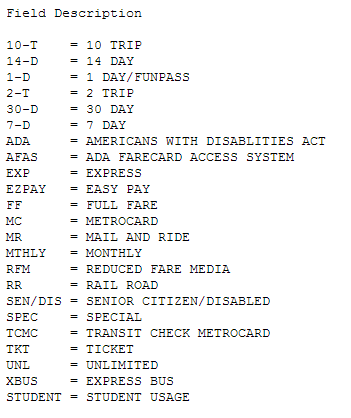

In [1]:
from IPython.display import Image
Image(filename = "Ridetypes.png")

In [859]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pylab as pl
import matplotlib.mlab as mlab
import heapq
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from collections import Counter
from scipy.spatial.distance import cdist, pdist
from sklearn.cluster import KMeans
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['average']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [851]:
mtaRides = np.load("MTA_Fare.npy")

## Task 1: 
### Event detection: Identify the most prominent event. There is a very significant drop (>3-sigma) in all time series.
### Identify it, figure out the date (you know when the data starts and what the cadence is) and figure out what it is due to.


## Task 2: 
### Some of the time series are stationary, some have a complex structure, some show a downward trend: Identify the **ridership types**  that have steadily increased in popularity,  and that have steadily decreased. by how much? (e.g what is the ratio of usage in the first 10 and last 10 weeks)


## Task 3:
### Several stations show a prominent annual periodicity. Identify the 4 **stations** (indentify them by the index of their location in the data cube) that show the most prominent periodic trend on an annual period (52 weeks). (Can you figure out what the periodic peak in rides is due to?)


## EXTRA CREDIT: Cluster. 
### Cluster the time series, i.e. identify groups of time series that look similar among each other. You can use KMeans for example to identify common trends, or PCA (Principle Component Analysis). 
### Since this is extra credit I will leave it to you to figure out the details, but for KMeans for e.g. if you use the sklearn.cluster package it would look something like:

#i am flattening the first 2 dimensions of the cube to cluster all light curves for all stations and all types

```
tots = data.transpose(2,0,1).reshape(data.shape[2], data.shape[1]*data.shape[0]).T
```

#removing empty light curves
```
tots = tots[tots.std(1)>0]
```

#with Kmeans you have to choose the number of clusters ahead km = 

```
KMeans(n_clusters=10)
```

#and standardize the lightcurves before clustering. Notice: standardize, not whiten! If you have done clustering before you may have whitened the data: removed the variance by "column", here you want to remove the variance by "row". We will discuss this in the clustering lecture. 
```
vals = ((tots.T - tots.mean(1))/tots.std(1)).T
```

#then you can run:

```
km.fit(vals)
```

In [815]:
mtaRides.shape

(600, 23, 194)

ride types list

In [816]:
ridetype = np.array(['10t', '14d', '1d', '2t', '30d', '7d', 'ada', 'afas', 'exp','ez',
            'ff','mc','mr','month','rfm','rr','sen','spec','tcmc','t',
            'umlim','xbus','stud'])

In [817]:
len(ridetype)

23

In [853]:
mtaStations1 = mtaRides.sum(axis = 1)
mtaStations1.shape

(600, 194)

In [854]:
mtaStations1Diff = mtaStations1.copy()

In [855]:
for i in range(0,len(mtaStations1)):
    average = pd.rolling_mean(mtaStations1[i],10)
    mtaStations1Diff[i][0:9] = 0
    mtaStations1Diff[i][9:] = mtaStations1[i][9:] - average[9:]

/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:2: FutureWarning: pd.rolling_mean is deprecated for ndarrays and will be removed in a future version
  from ipykernel import kernelapp as app


In [856]:
maxindex=[]
for i in range(0,len(mtaStations1)):
    largest=heapq.nlargest(1, abs(mtaStations1Diff[i]))
    maxindex.append(np.where(abs(mtaStations1Diff[i])==largest)[0][0])

In [857]:
from collections import Counter
Counter(maxindex).most_common(3)
# This means 126th week has the most significant change in 388 stations.
# Besides, 129 stations has no data.

[(126, 388), (0, 129), (127, 38)]

In [858]:
# An alternative way is to count each type of card for each station.
mtaRidesDiff = mtaRides.copy()
for i in range(0,len(mtaRides)):
    for k in range(0,len(mtaRides[i])):
        temp = mtaRides[i][k]
        temp = temp[temp>0]
        average = temp.sum()/len(temp)
        mtaRidesDiff[i][k] = mtaRides[i][k] - average
        Diff = mtaRidesDiff[i][k]
        Diff[Diff == -1 - average]=0
index_maxDiff = []
for i in range(0,len(mtaRidesDiff)):
    for k in range(0,len(mtaRidesDiff[i])):
        temp = np.absolute(mtaRidesDiff[i][k])
        index = temp.argmax(axis=0)
        index_maxDiff.append(index)
index_maxDiff_nonzero = filter(lambda a: a>0, index_maxDiff)
index_maxDiff_nonzero[0:10]
Counter(index_maxDiff_nonzero).most_common(2)
# The result is the same

[(126, 2998), (36, 517)]

### After 126 week, the date range is 2012/10/26 to 2012 11/02
### The reason is Hurricane Sandy.

# Task 2

In [912]:
mtaRides_nonzero = mtaRides.copy()
mtaRides_nonzero[mtaRides_nonzero == -1] = 0
mtacard = mtaRides_nonzero.sum(axis = 0)
#mtacard = filter(lambda a: a>0, mtacard)

/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:7: FutureWarning: pd.rolling_mean is deprecated for ndarrays and will be removed in a future version


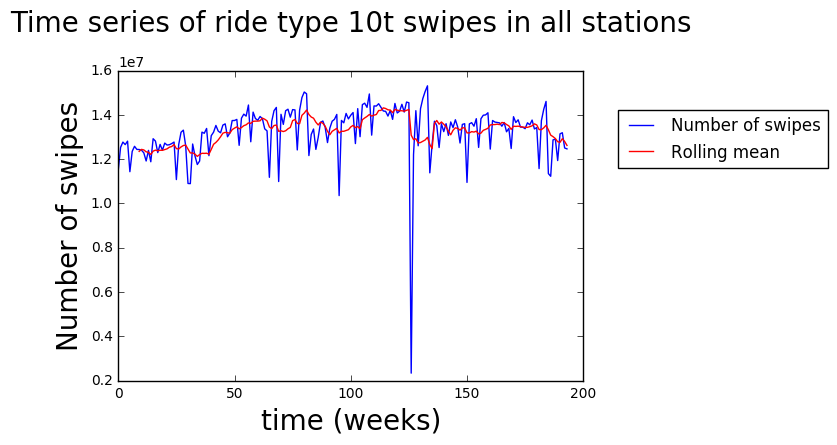

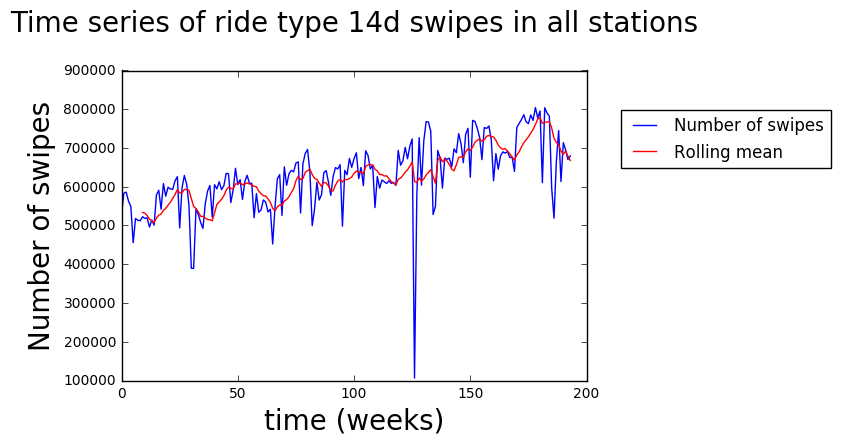

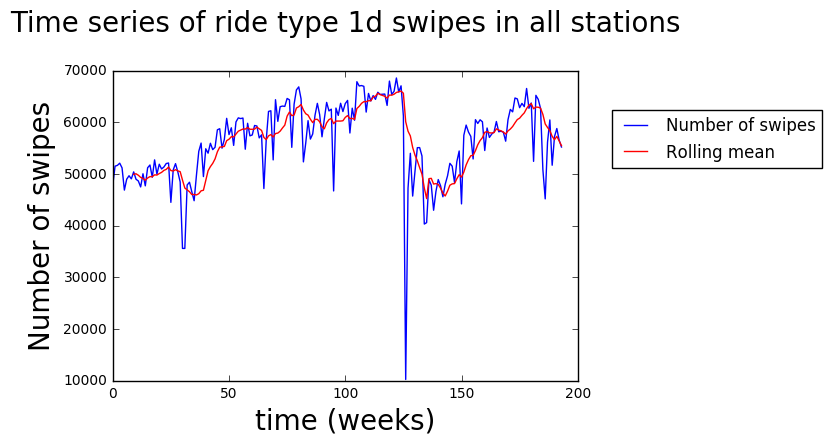

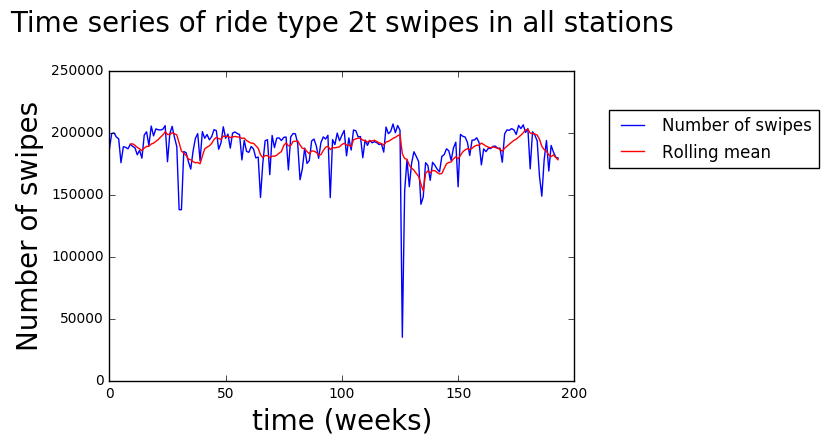

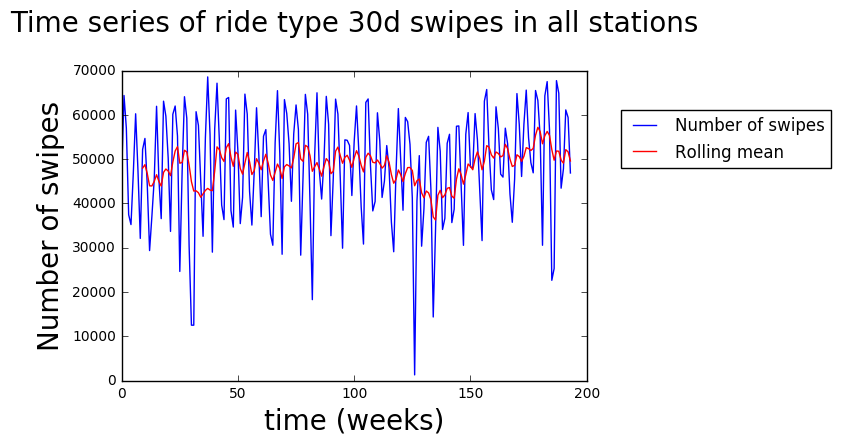

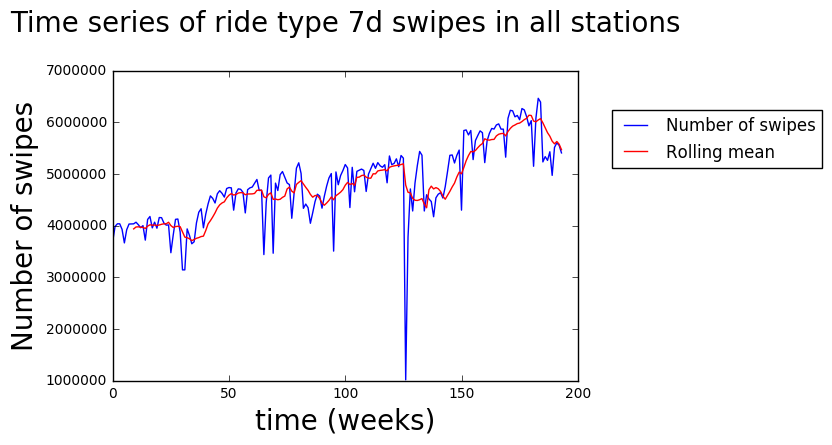

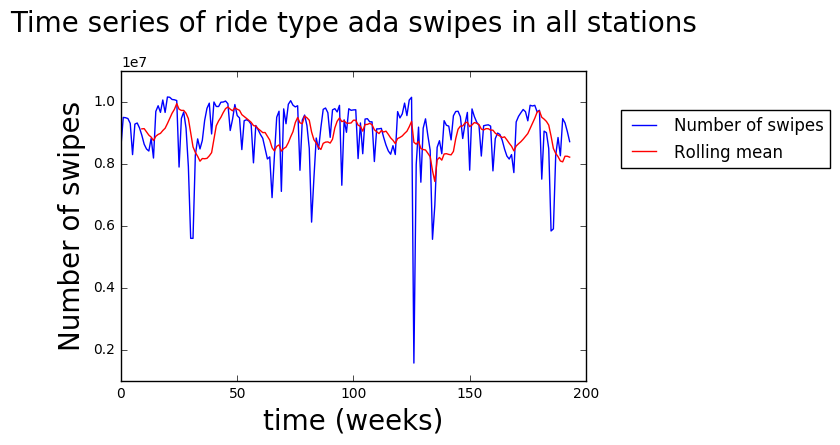

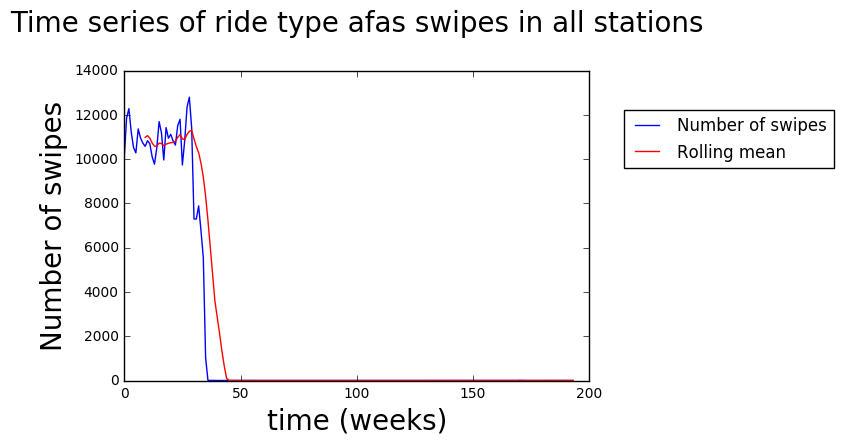

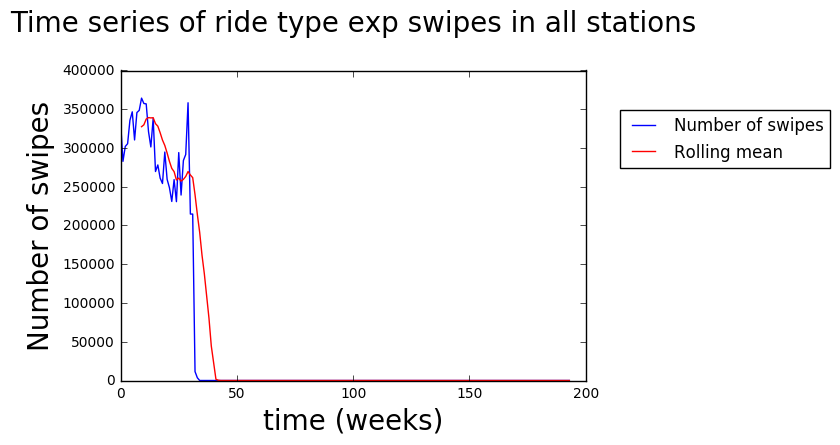

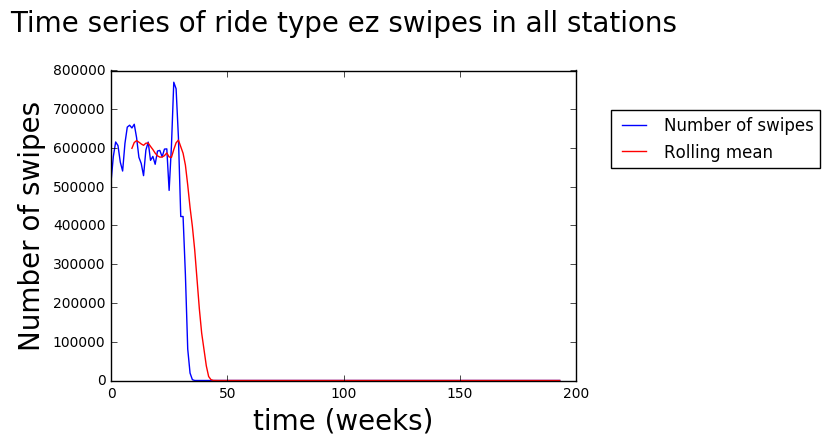

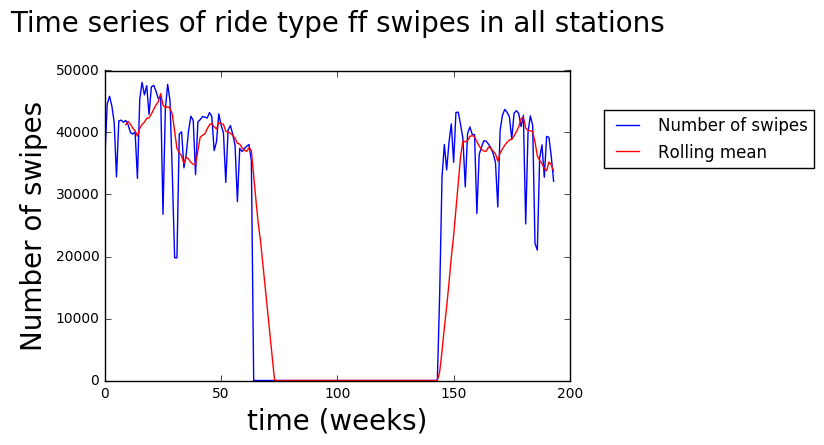

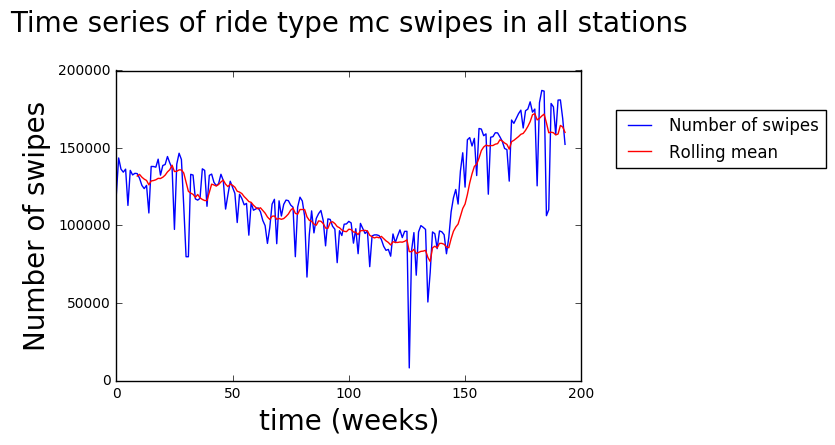

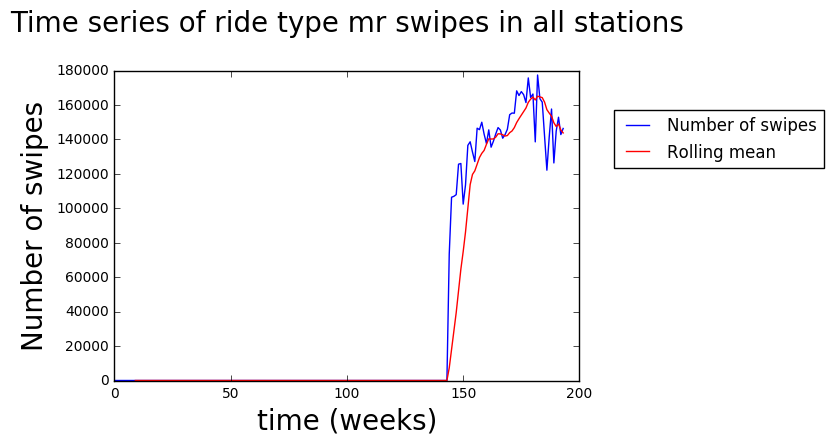

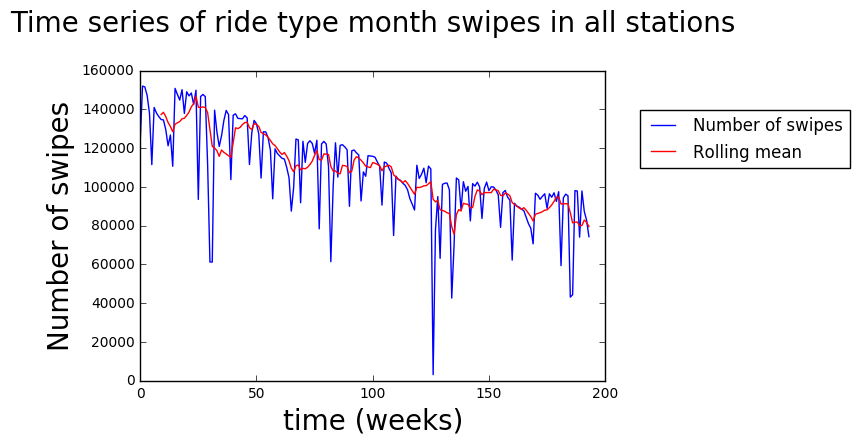

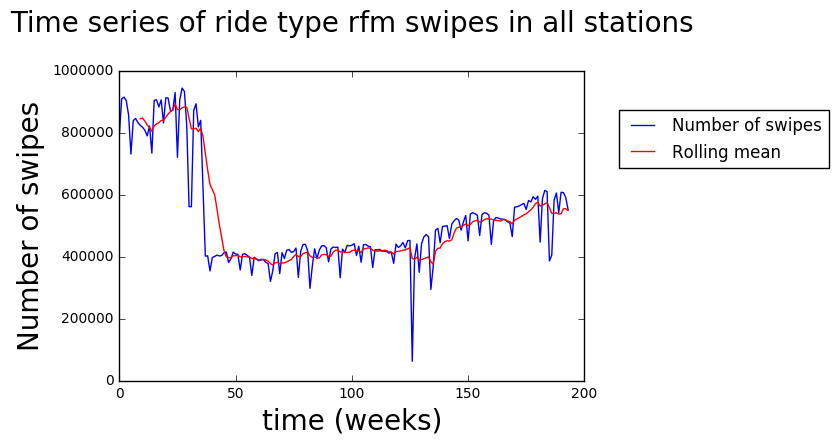

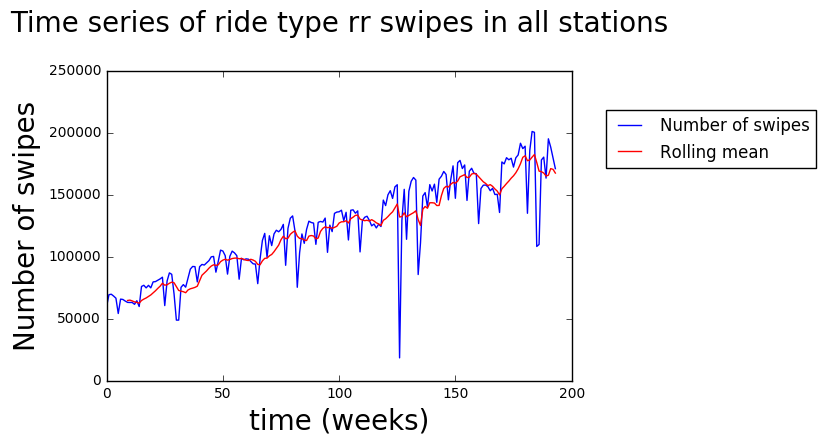

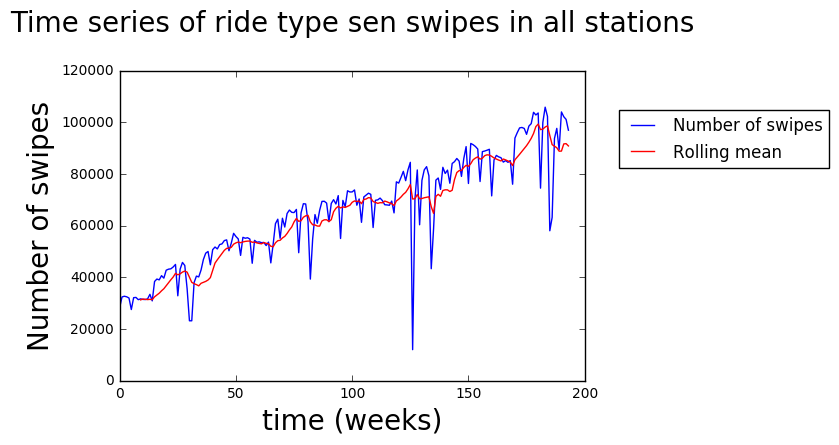

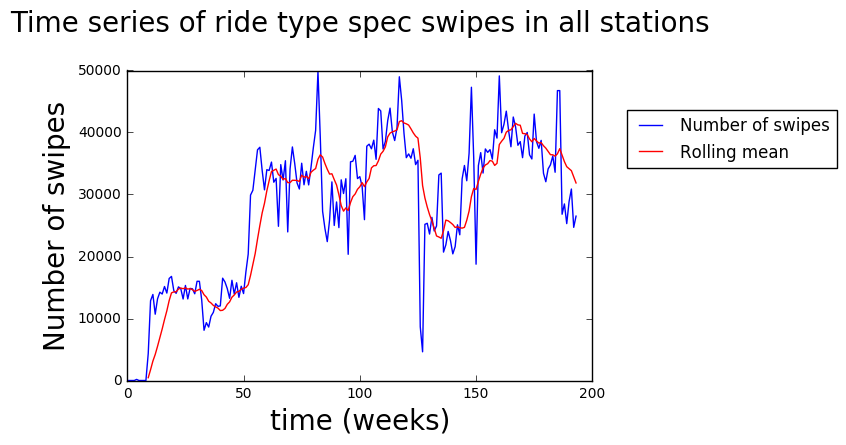

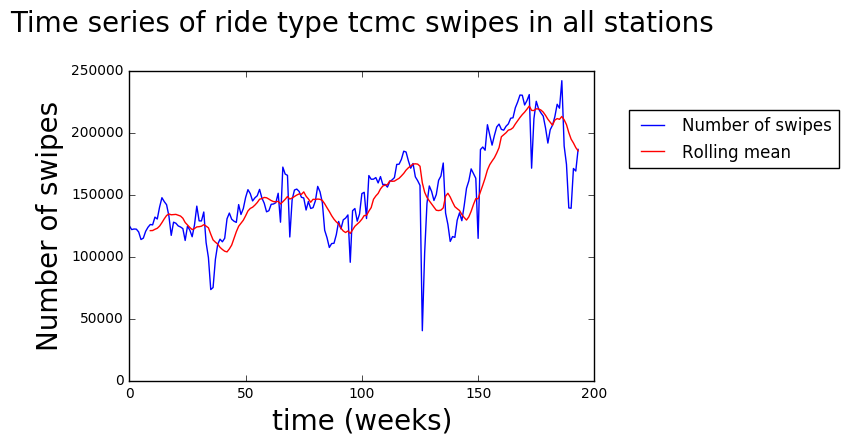

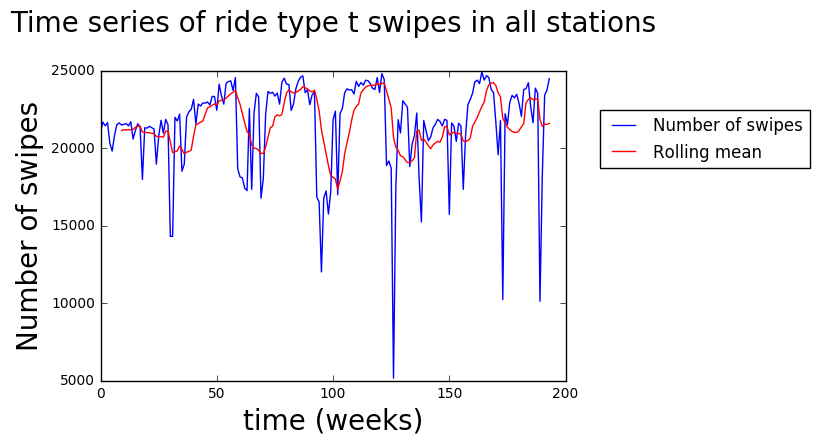

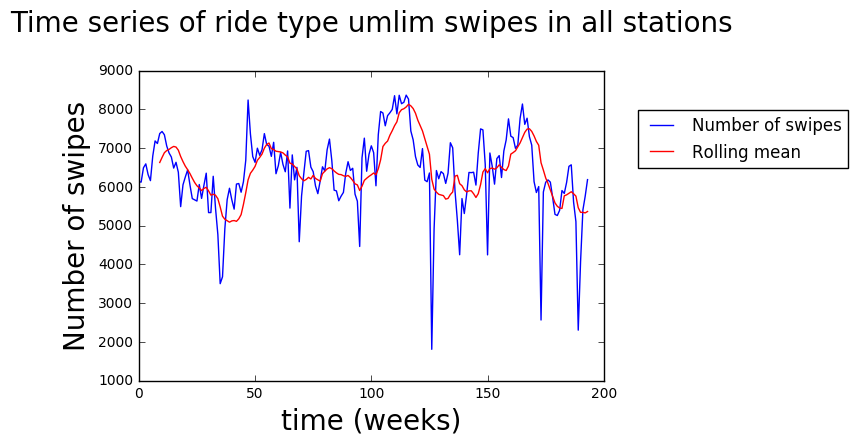

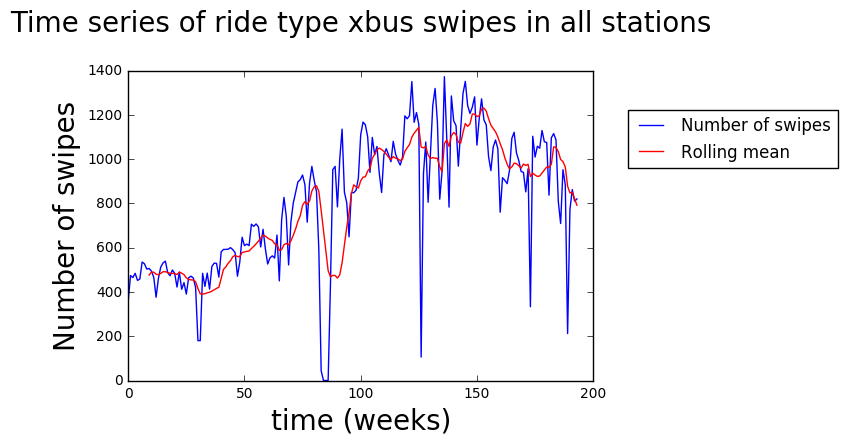

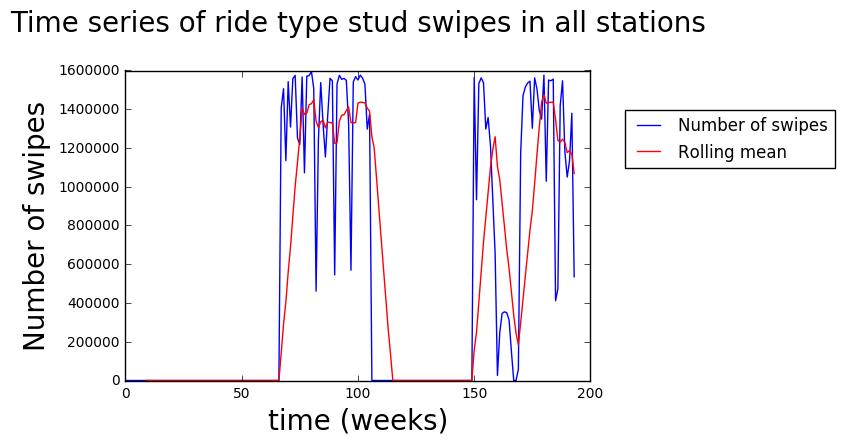

In [1007]:
first10 = []
last10 = []
ratio = []
std = []
for i in range (0,23):
    fig = plt.figure()
    average = pd.rolling_mean(mtacard[i],10)
    plot(mtacard[i], label = 'Number of swipes')
    plot(average, color = 'r', label = 'Rolling mean')
    pylab.legend(loc=9, bbox_to_anchor = (1.3, 0.9))
    title('Time series of ride type ' + str(ridetype[i]) \
          + ' swipes in all stations\n', fontsize = 20)
    xlabel('time (weeks)', fontsize = 20)
    ylabel('Number of swipes', fontsize = 20)
    first10.append(average[9])
    last10.append(average[-1])
    ratio.append(average[-1] /  average[9])
    std.append(np.std(mtacard[i]))

In [1008]:
dfratio = pd.DataFrame(ratio, columns=["ratio"], index = ridetype)  

In [1009]:
dfratio['std'] = std
dfratio['std/mean'] = meanbystd

In [1010]:
dfratio[dfratio.ratio > 1.2]

,ratio,std,std/mean
14d,1.252065e+00,90631.594000,6.928158
7d,1.389748e+00,763049.861181,6.283540
mc,1.213541e+00,29656.855316,4.045304
mr,2.478493e+04,63142.328345,0.581401
rr,2.592960e+00,38211.214367,3.194507
sen,2.909397e+00,20717.296939,3.149735
spec,7.018238e+01,12072.607484,2.283351
tcmc,1.532271e+00,34885.915210,4.366232
xbus,1.662327e+00,304.104385,2.624099
stud,inf,667620.847071,0.763976


In [1011]:
# The ratio of usage in the first 10 and last 10 weeks which are larger than 1.2 is shown.
# 14d, 7d, mr, rr, sen, spec, tcmc, xbus, stud have increasing trend
# stud is not stable according to the plot.
# mc decreases at first and increases recently.

In [1012]:
dfratio[dfratio.ratio < 0.8]

,ratio,std,std/mean
afas,0.000209,4061.960231,0.464308
exp,0.000011,110873.907982,0.439310
ez,0.000002,221304.421975,0.449187
month,0.578722,23741.907839,4.544622
rfm,0.649608,171277.595789,3.050819


In [1013]:
# The ratio of usage in the first 10 and last 10 weeks which is smaller than 1.2 is shown.
# month have decresing trend
# rfm decreases suddenly at first and gradually increasing.
# afas, exp and ez drop suddenly at some points and remain almost 0.

In [1014]:
temp = dfratio[dfratio.ratio >= 0.8]
temp[temp.ratio <= 1.2]

,ratio,std,std/mean
10t,1.021798,1.212509e+06,10.921460
1d,1.111345,7.599227e+03,7.410095
2t,0.933803,1.759059e+04,10.642394
30d,1.033787,1.263384e+04,3.843409
ada,0.899841,1.053450e+06,8.503948
ff,0.818802,1.963051e+04,1.158044
t,1.021589,2.926566e+03,7.371780
umlim,0.809064,1.017792e+03,6.261593


In [1015]:
# Others do not have significant ratio change.

# Task 3

In [569]:
ff=[] #store value of rfft
ff3=[] # store value of ff[i][3]

In [570]:
#Since 1/periods[3] = 48.5, we use it instead of 52.
#ff[i][3] is the fourier transform value at period 48.5

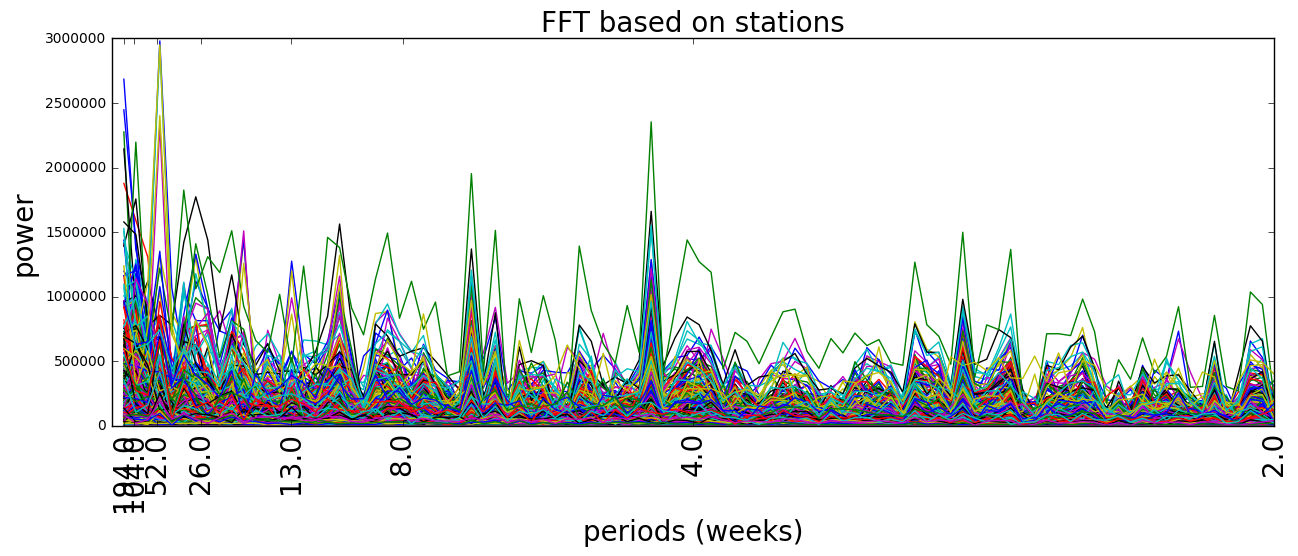

In [571]:
fig = plt.figure(figsize=(15,5))
for i in range(len(mtaStations)):
    ff.append(np.abs(np.fft.rfft(mtaStations[i]))[1:])
    ax = fig.add_subplot(111)
    periods = np.fft.rfftfreq(len(mtaStations[i]))[1:]
    ff3.append(ff[i][3])
    ax.plot(periods, ff[i])
allperiods = [1.0/194, 1.0/104, 1.0/52, 1.0/26, 1.0/13, 1.0/8, 1.0/4, 1.0/2]
ax.set_xticks(allperiods)
ax.set_xticklabels(["%s"%(1/f) for f in allperiods], rotation=90, fontsize=20)
ax.set_xlabel("periods (weeks)", fontsize=20)
ax.set_ylabel("power", fontsize=20)
ax.set_title("FFT based on stations", fontsize=20)

In [1016]:
ff3_sort = ff3[:]

In [1017]:
sorted(ff3_sort,reverse=1)[0:4]

[2980184.9113423442,
 2950375.4711558297,
 2931882.3472655215,
 2402206.9930728795]

In [1021]:
ff3_4=heapq.nlargest(4, ff3)
L4=[]
for i in range(0,4):
    L4.append(np.where(ff3==ff3_4[i])[0][0])
L4

[0, 194, 150, 327]

In [1022]:
mtaStations = mtaRides.sum(axis = 1)
mtaStations.shape

(600, 194)

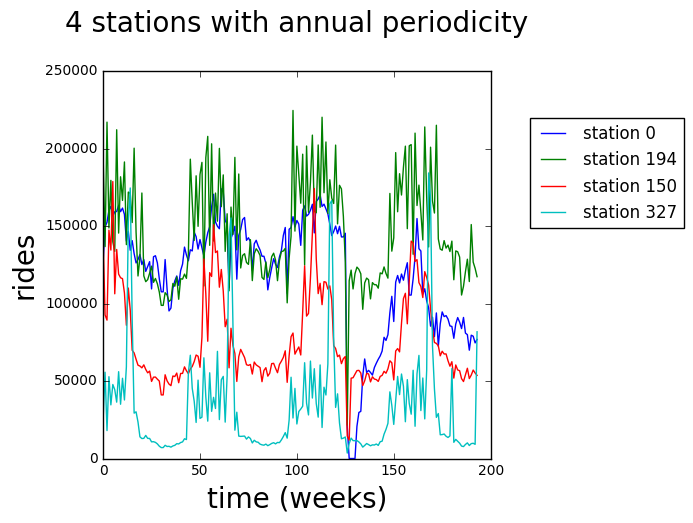

In [1023]:
fig = plt.figure(figsize=(5,5))
for i in L4:
    plot(mtaStations[i], label = "station"+' '+ str(i))
pylab.legend(loc=9, bbox_to_anchor=(1.3, 0.9))
xlabel("time (weeks)", fontsize=20)
ylabel("rides", fontsize=20)
ylim(0, 250000)
title("4 stations with annual periodicity\n", fontsize=20)

# Extra Credit

In [1024]:
def elbow(data,K):
#data is input as numpy form
#K is a list of number of clusters you would like to show.
    # Run the KMeans model and save all the results for each number of clusters
    KM = [KMeans(n_clusters=k).fit(data) for k in K]
    
    # Save the centroids for each model with a increasing k
    centroids = [k.cluster_centers_ for k in KM]

    # For each k, get the distance between the data with each center. 
    D_k = [cdist(data, cent, 'euclidean') for cent in centroids]
    
    # But we only need the distance to the nearest centroid since we only 
    # calculate dist(x,ci) for its own cluster.
    globals()['dist'] = [np.min(D,axis=1) for D in D_k]
    
    # Calculate the Average SSE.
    avgWithinSS = [sum(d)/data.shape[0] for d in dist]
    
    
    # elbow curve
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(K, avgWithinSS, 'b*-')
    plt.grid(True)
    plt.xlabel('Number of clusters')
    plt.ylabel('Average within-cluster sum of squares')
    plt.title('Elbow for KMeans clustering')
    plt.show()
    
    
    # Total with-in sum of square plot. Another way to show the result.
    wcss = [sum(d**2) for d in dist]
    tss = sum(pdist(data)**2)/data.shape[0]
    bss = tss-wcss
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(K, bss/tss*100, 'b*-')
    plt.grid(True)
    plt.xlabel('Number of clusters')
    plt.ylabel('Percentage of variance explained')
    plt.title('Elbow for KMeans clustering')
    plt.show()

In [1068]:
mtaRides_float = np.load("MTA_Fare.npy").astype(float)

In [1069]:
mtaRides_float[mtaRides_float == -1] = np.nan

In [1070]:
tots = mtaRides_float.transpose(2,0,1).reshape(mtaRides_float.shape[2], \
                                         mtaRides_float.shape[1] * mtaRides_float.shape[0]).T
tots = tots[tots.std(1) > 0]

In [1071]:
tots_std = (tots - np.nanmean(tots, axis=0)) / np.nanstd(tots, axis=0) # Written by Yao Wang

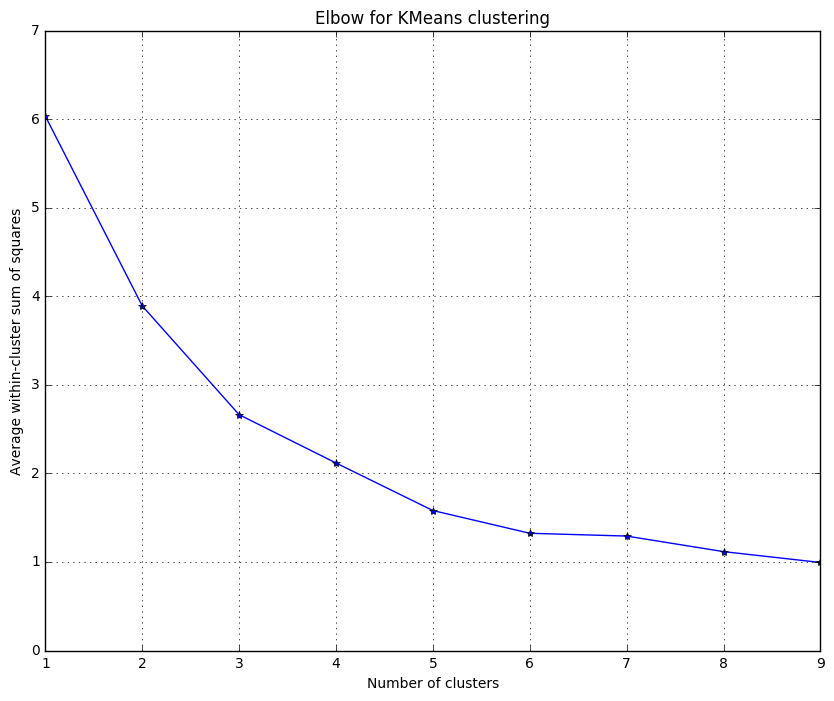

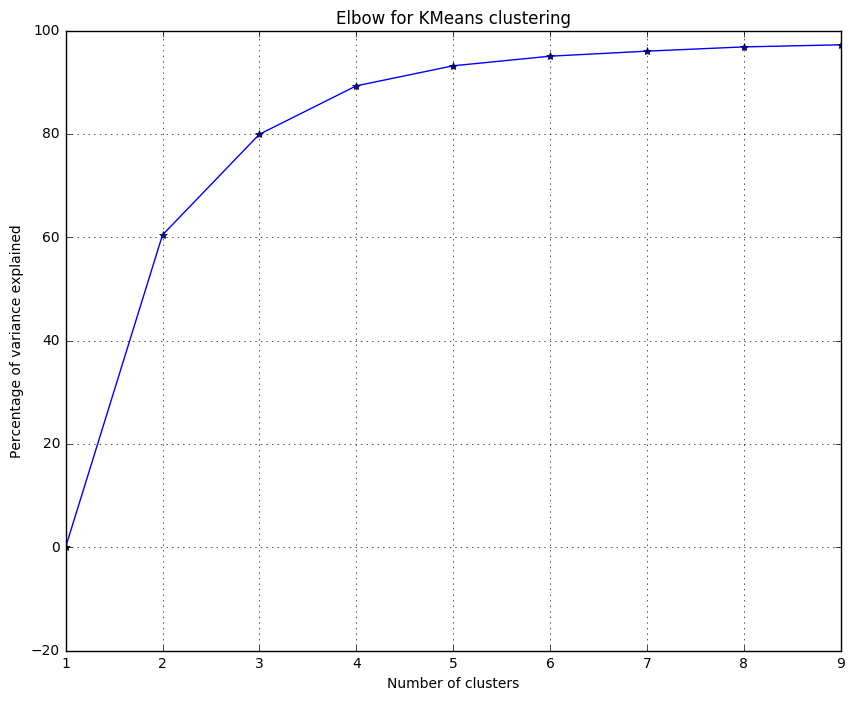

In [1076]:
elbow(tots_std, range(1,10))

In [1101]:
def silhouette_score_plot(data,range_n_clusters):
    X=data
    for n_clusters in range_n_clusters:
        
        fig = plt.figure()
        fig.patch.set_alpha(0.5)
        fig.set_size_inches(15, 10)
        ax = fig.add_subplot(111)
        
        # Initialize the clusterer with n_clusters value and a random generator
        # seed of 10 for reproducibility.
        clusterer = KMeans(n_clusters=n_clusters, random_state=324)
        cluster_labels = clusterer.fit_predict(X)

        # The silhouette_score gives the average value for all the samples.
        # This gives a perspective into the density and separation of the formed
        # clusters
        silhouette_avg = silhouette_score(X, cluster_labels)

        print("For n_clusters =", n_clusters,
              "The average silhouette_score is :", silhouette_avg)

        # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(X, cluster_labels)

        y_lower = 10
        for i in range(n_clusters):
            # Aggregate the silhouette scores for samples belonging to
            # cluster i, and sort them
            ith_cluster_silhouette_values = \
                sample_silhouette_values[cluster_labels == i]

            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.spectral(float(i) / n_clusters)
            # Label the silhouette plots with their cluster numbers at the middle
            #ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        colors = cm.spectral(cluster_labels.astype(float) / n_clusters)
        ax.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                    c=colors)

        # Labeling the clusters

        ax.set_title("The visualization of the clustered data\n")
        ax.set_xlabel("Feature space for the 1st feature")
        ax.set_ylabel("Feature space for the 2nd feature")

        plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                      "with n_clusters = %d" % n_clusters),
                     fontsize=14, fontweight='bold')

        plt.show()

('For n_clusters =', 5, 'The average silhouette_score is :', 0.86711551275027987)


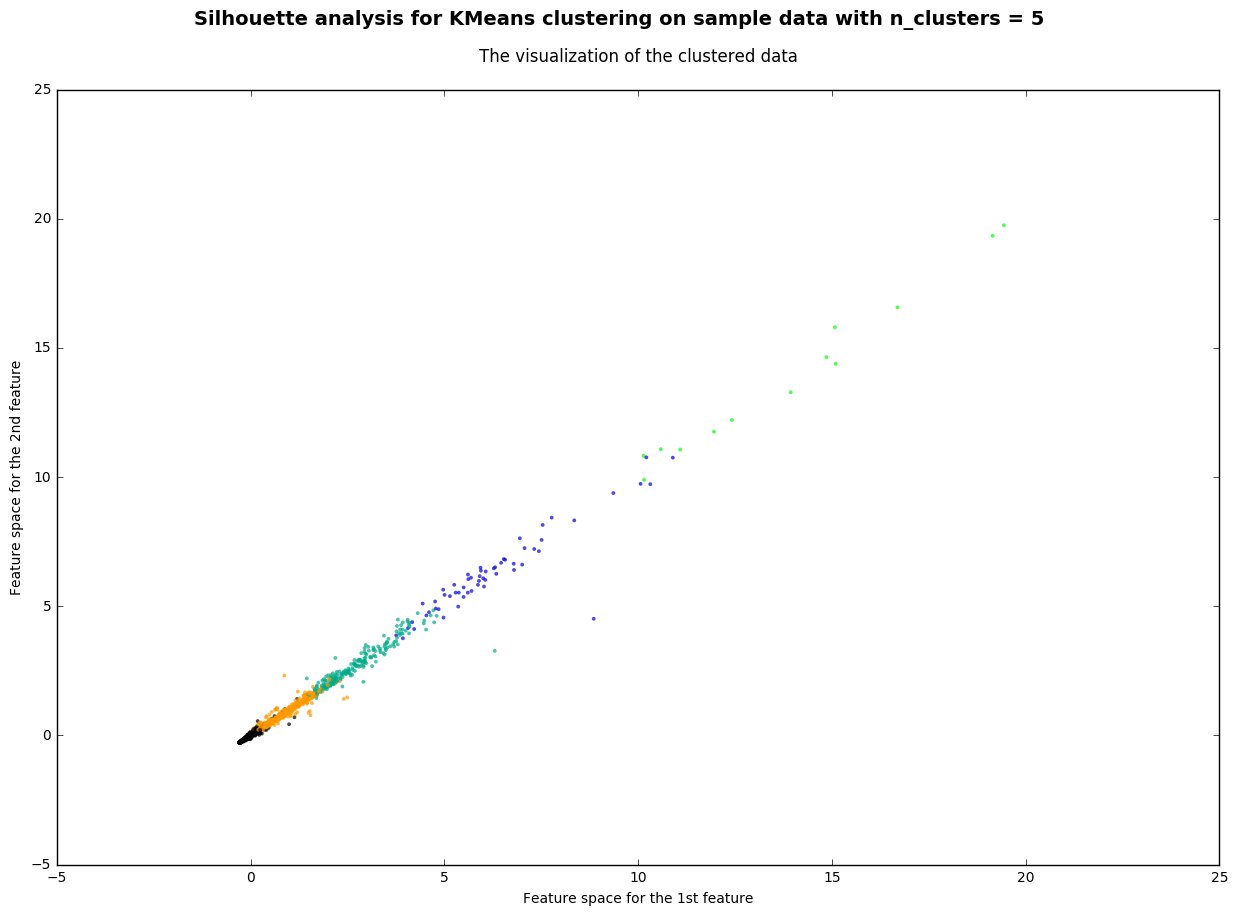

In [1102]:
silhouette_score_plot(tots_std, range(5,6))